<a href="https://colab.research.google.com/github/s-im-ran/Deep-Learning/blob/main/CNN_seticlassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import confusion_matrix
from sklearn import metrics
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback
import warnings;warnings.simplefilter('ignore')
print('Tensorflow version',tf.__version__)

from tensorflow.keras.callbacks import EarlyStopping



Tensorflow version 2.12.0


In [ ]:
train_images=pd.read_csv('/content/drive/My Drive/dataset/train/images.csv',header=None)
train_labels=pd.read_csv('/content/drive/My Drive/dataset/train/labels.csv',header=None)
val_images=pd.read_csv('/content/drive/My Drive/dataset/validation/images.csv',header=None)
val_labels=pd.read_csv('/content/drive/My Drive/dataset/validation/labels.csv',header=None)

In [ ]:
print("testing dataset",train_images.shape,train_labels.shape)

testing dataset (3200, 8192) (3200, 4)


In [ ]:
print("training datset",train_labels.shape,val_labels.shape)

training datset (3200, 4) (800, 4)


In [ ]:
train_images.head(3)

,0,1,2,3,4,5,6,7,8,9,...,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,...,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,...,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,...,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510


In [ ]:
train_labels.head(3)

,0,1,2,3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0


In [ ]:
x_train=train_images.values.reshape(3200,64,128,1)
y_train=train_labels.values
y_val=val_labels.values
x_val=val_images.values.reshape(800,64,128,1)

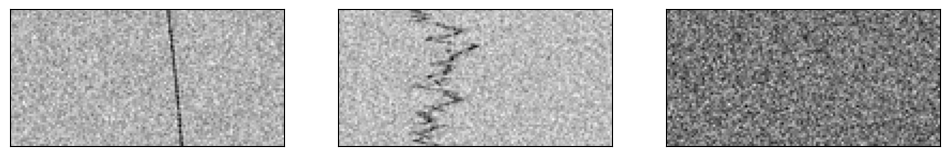

In [ ]:
plt.figure(0,figsize=(12,12))
for i in range(1,4):
  plt.subplot(1,3,i)
  img=np.squeeze(x_train[np.random.randint(0,x_train.shape[0])])
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img,cmap='gray')

In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train=ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)
datagen_val=ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

In [ ]:
from tensorflow.keras.layers import Dense,Input,Dropout,Flatten,Conv2D
from tensorflow.keras.layers import BatchNormalization,Activation,MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
cnn = Sequential()
#Adding 1 Convolution Layer
cnn.add(Conv2D(filters=32,kernel_size=5,activation="relu",padding="same", input_shape=(64,128,1)))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=2, strides=2))
cnn.add(Dropout(0.2))

#Adding 2 Convolution Layer
cnn.add(Conv2D(filters=32,kernel_size=5,activation="relu",padding="same"))
cnn.add(BatchNormalization())
cnn.add(MaxPooling2D(pool_size=2, strides=2))
cnn.add(Dropout(0.2))

# Adding Flattening
cnn.add(Flatten())

# Adding fully connected layer
cnn.add(Dense(units=1024, activation="relu"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.4))

cnn.add(Dense(4, activation='softmax'))

In [ ]:
initial_learning_rate = 0.005
learning_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,decay_steps=5,decay_rate=0.96,staircase=True)
# This will calculate 0.005 * (0.96 **5) in every 5 steps and recalculate learning steps and the result of this operation as the leanring step
optimizer = Adam(learning_rate=learning_schedule)

In [ ]:
cnn.compile(optimizer=optimizer, loss="categorical_crossentropy",metrics=["accuracy"])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 128, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 64, 128, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 64, 32)        25632     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 64, 32)       1

In [ ]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss',
                             save_weights_only=True, mode='min', verbose=0)
callbacks = [early_stopping, checkpoint]

batch_size = 32

history = cnn.fit(datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                  steps_per_epoch=len(x_train) // batch_size,
                  validation_data=datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
                  validation_steps=len(x_val) // batch_size,epochs=12,
                  callbacks=callbacks
)

Epoch 1/12
100/100 [==============================] - 24s 41ms/step - loss: 0.7328 - accuracy: 0.6772 - val_loss: 13.7107 - val_accuracy: 0.2500
Epoch 2/12
100/100 [==============================] - 2s 23ms/step - loss: 0.5021 - accuracy: 0.7206 - val_loss: 36.1984 - val_accuracy: 0.2500
Epoch 3/12
100/100 [==============================] - 3s 25ms/step - loss: 0.4287 - accuracy: 0.7481 - val_loss: 16.6021 - val_accuracy: 0.6500
Epoch 4/12
100/100 [==============================] - 3s 25ms/step - loss: 0.4194 - accuracy: 0.7434 - val_loss: 46.0454 - val_accuracy: 0.5000
Epoch 5/12
100/100 [==============================] - 4s 44ms/step - loss: 0.4021 - accuracy: 0.7506 - val_loss: 39.9056 - val_accuracy: 0.4988
Epoch 6/12
100/100 [==============================] - 3s 34ms/step - loss: 0.3881 - accuracy: 0.7534 - val_loss: 13.2196 - val_accuracy: 0.5038
Epoch 7/12
100/100 [==============================] - 4s 35ms/step - loss: 0.3913 - accuracy: 0.7509 - val_loss: 4.9427 - val_accuracy:

In [ ]:
cnn.evaluate(x_val,y_val)

25/25 [==============================] - 0s 6ms/step - loss: 1.0481 - accuracy: 0.6137


[1.0480693578720093, 0.6137499809265137]

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true=np.argmax(y_val,1)
y_pred=np.argmax(cnn.predict(x_val),1)
print(metrics.classification_report(y_true,y_pred))

25/25 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       1.00      0.33      0.50       200
           1       0.36      0.48      0.41       200
           2       0.48      0.64      0.55       200
           3       1.00      1.00      1.00       200

    accuracy                           0.61       800
   macro avg       0.71      0.61      0.62       800
weighted avg       0.71      0.61      0.62       800



In [ ]:
print("classification Accuracy : %0.6f" %metrics.accuracy_score(y_true,y_pred))

classification Accuracy : 0.613750


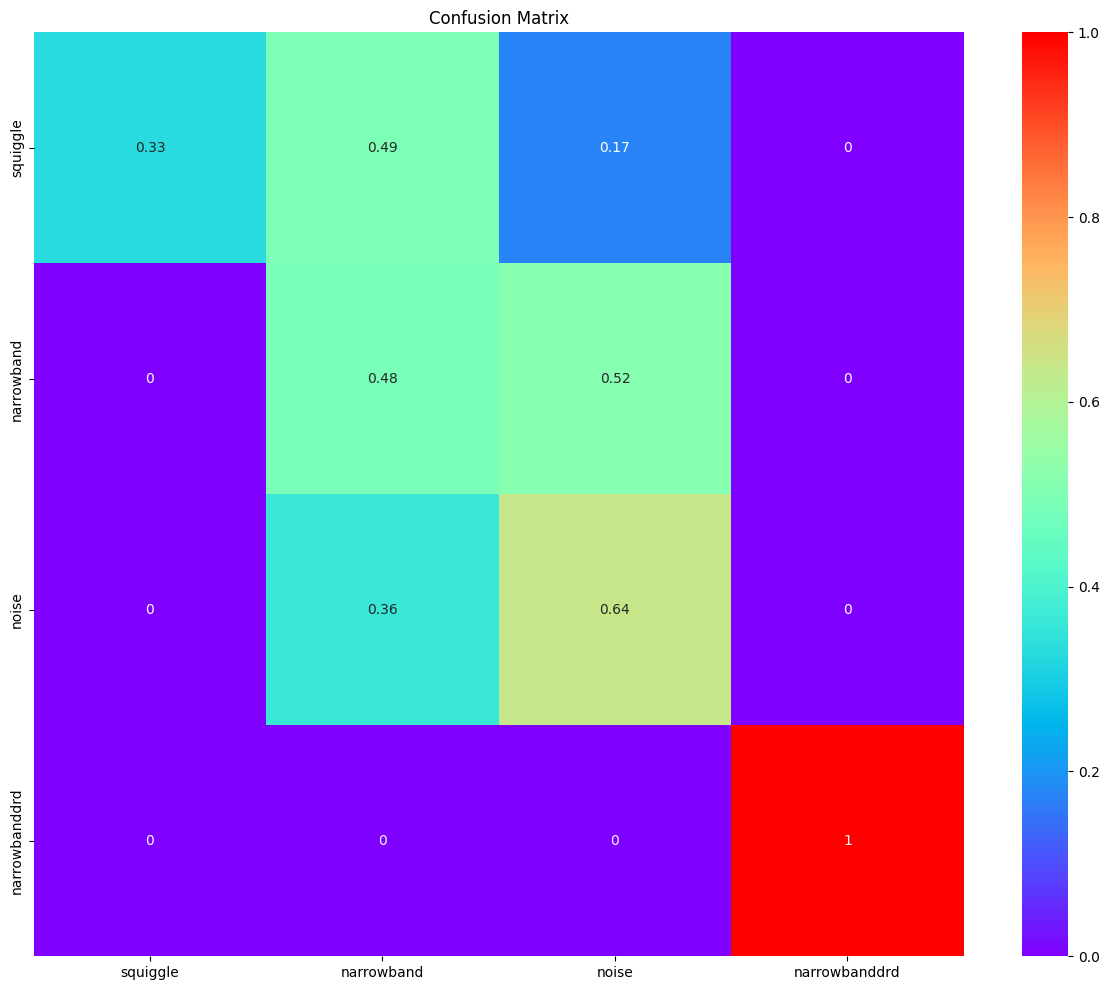

In [ ]:
labels=["squiggle","narrowband","noise","narrowbanddrd"]
plt.figure(figsize=(15,12))
ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax=ax,cmap="rainbow"); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);